*Accompanying code examples of the book "Introduction to Artificial Neural Networks and Deep Learning: A Practical Guide with Applications in Python" by [Sebastian Raschka](https://sebastianraschka.com). All code examples are released under the [MIT license](https://github.com/rasbt/deep-learning-book/blob/master/LICENSE). If you find this content useful, please consider supporting the work by buying a [copy of the book](https://leanpub.com/ann-and-deeplearning).*
  
Other code examples and content are available on [GitHub](https://github.com/rasbt/deep-learning-book). The PDF and ebook versions of the book are available through [Leanpub](https://leanpub.com/ann-and-deeplearning).

# Storing an Image Dataset for Minibatch Training using HDF5

This notebook provides an example for how to save a large dataset of images as Hierarchical Data Format (HDF) for quick access during minibatch learning. This approach uses the common [HDF5](https://support.hdfgroup.org/HDF5/) format and should be accessible to any programming language or tool with an HDF5 API.

While this approach performs reasonably well (sufficiently well for my applications), you may also be interested in TensorFlow's "[Reading Data](https://www.tensorflow.org/programmers_guide/reading_data)" guide to work with `TfRecords` and file queues.

## 0. The Dataset

Let's pretend we have a directory of images containing two subdirectories with images for training, validation, and testing. The following function will create such a dataset of images in PNG format locally for demonstration purposes.

In [1]:
# Note that executing the following code 
# cell will download the MNIST dataset
# and save all the 60,000 images as separate PNG
# files. This might take a few minutes depending
# on your machine.

import numpy as np
from helper import mnist_export_to_jpg

np.random.seed(123)
mnist_export_to_jpg(path='./')

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


In [2]:
import os

for i in ('train', 'valid', 'test'):
    print('mnist_%s subdirectories' % i, os.listdir('mnist_%s' % i))

mnist_train subdirectories ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
mnist_valid subdirectories ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
mnist_test subdirectories ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


Note that the names of the subdirectories correspond directly to the class label of the images that are stored under it.

To make sure that the images look okay, the snippet below plots an example image from the subdirectory `mnist_train/9/`:

(28, 28)


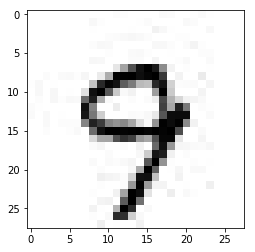

In [3]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os

some_img = os.path.join('./mnist_train/9/', os.listdir('./mnist_train/9/')[0])

img = mpimg.imread(some_img)
print(img.shape)
plt.imshow(img, cmap='binary');

Note: The JPEG format introduces a few artifacts that we can see in the image above. In this case, we use JPEG instead of PNG. Here, JPEG is used for demonstration purposes since that's still format many image datasets are stored in.

## 1. Saving images as HDF5

The following wrapper function creates .h5 file containing training, testing, and validation datasets. It will group images together into larger integer arrays that are then saved as subgroups in the HDF5 file. For instance, the training images will be saved as `'train/images'` and the corresponding labels as `'train/labels'` subgroup.

In [4]:
import numpy as np
import h5py
import glob


def images_to_h5(data_stempath='./mnist_',
                 width=28, height=28, channels=1,
                 shuffle=False, random_seed=None):
    
    with h5py.File('mnist_batches.h5', 'w') as h5f:
    
        for s in ['train', 'valid', 'test']:
            img_paths = [p for p in glob.iglob('%s%s/**/*.jpg' % 
                                       (data_stempath, s), 
                                        recursive=True)]

            dset1 = h5f.create_dataset('%s/images' % s, 
                                       shape=[len(img_paths), 
                                              width, height, channels], 
                                       compression=None,
                                       dtype='uint8')
            dset2 = h5f.create_dataset('%s/labels' % s, 
                                       shape=[len(img_paths)], 
                                       compression=None,
                                       dtype='uint8')
            
            rand_indices = np.arange(len(img_paths))
            
            if shuffle:
                rng = np.random.RandomState(random_seed)
                rng.shuffle(rand_indices)

            for idx, path in enumerate(img_paths):

                rand_idx = rand_indices[idx]
                label = int(os.path.basename(os.path.dirname(path)))
                image = mpimg.imread(path)
                dset1[rand_idx] = image.reshape(width, height, channels)
                dset2[rand_idx] = label

Note that we didn't specify any compression format. The reason is that non-compressed HDF5 datasets are much faster to read, which is an important factor for training deep learning systems. In this case, the dataset is about ~47 Mb in size. However, we are working with larger datasets, compressing the HDF5 dataset might be one easy way to deal with hardware storage limitations.

In [5]:
images_to_h5(shuffle=True, random_seed=123)

To check that the archiving worked correctly, we will now load the training images and print the array shape. Note that we can now access each archive similar to a python dictionary. Here the `'data'` key contains the image data and the `'labels'` key stores an array containing the corresponding class labels:

In [6]:
with h5py.File('mnist_batches.h5', 'r') as h5f:
    print(h5f['train/images'].shape)
    print(h5f['train/labels'].shape)

(45000, 28, 28, 1)
(45000,)


Class label: 8


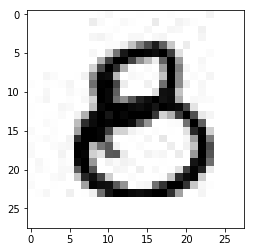

In [7]:
with h5py.File('mnist_batches.h5', 'r') as h5f:

    plt.imshow(h5f['train/images'][0][:, :, -1], cmap='binary');
    print('Class label:', h5f['train/labels'][0])

## 2. Loading Minibatches

The following cell implements a class for iterating over the MNIST images, based on the .h5 file, conveniently. 
Via the `normalize` parameter we additionally scale the image pixels to [0, 1] range, which typically helps with gradient-based optimization in practice.

The key functions (here: generators) are

- load_train_epoch
- load_valid_epoch
- load_test_epoch

These let us iterate over small chunks (determined via `minibatch_size`) and yield minibatches via memory-efficient Python generators. Via the two shuffle parameters, we can further control if the images within each batch to be shuffled. By setting `onehot=True`, the labels are converted into a onehot representation for convenience.

In [8]:
class BatchLoader():
    def __init__(self, minibatches_path, 
                 normalize=True):
        
        self.minibatches_path = minibatches_path
        self.normalize = normalize
        self.num_train = 45000
        self.num_valid = 5000
        self.num_test = 10000
        self.n_classes = 10


    def load_train_epoch(self, batch_size=50, onehot=False,
                         shuffle_batch=False, seed=None):
        for batch_x, batch_y in self._load_epoch(which='train',
                                                 batch_size=batch_size,
                                                 onehot=onehot,
                                                 shuffle_batch=shuffle_batch,
                                                 seed=seed):
            yield batch_x, batch_y

    def load_test_epoch(self, batch_size=50, onehot=False,
                        shuffle_batch=False, seed=None):
        for batch_x, batch_y in self._load_epoch(which='test',
                                                 batch_size=batch_size,
                                                 onehot=onehot,
                                                 shuffle_batch=shuffle_batch,
                                                 seed=seed):
            yield batch_x, batch_y
            
    def load_validation_epoch(self, batch_size=50, onehot=False,
                              shuffle_batch=False, seed=None):
        for batch_x, batch_y in self._load_epoch(which='valid',
                                                 batch_size=batch_size,
                                                 onehot=onehot,
                                                 shuffle_batch=shuffle_batch,
                                                 seed=seed):
            yield batch_x, batch_y

    def _load_epoch(self, which='train', batch_size=50, onehot=False,
                    shuffle_batch=False, seed=None):
        
        if shuffle_batch:
            rgen = np.random.RandomState(seed)

        with h5py.File(self.minibatches_path, 'r') as h5f:
            indices = np.arange(h5f['%s/images' % which].shape[0])
            for start_idx in range(0, indices.shape[0] - batch_size + 1,
                                   batch_size):

                x_batch = h5f['%s/images' % which][start_idx:start_idx + batch_size]
                x_batch = x_batch.astype(np.float32)
                y_batch = h5f['%s/labels' % which][start_idx:start_idx + batch_size]

                if onehot:
                    y_batch = (np.arange(self.n_classes) == 
                               y_batch[:, None])

                if self.normalize:
                    # normalize to [0, 1] range
                    x_batch = x_batch.astype(np.float32) / 255.

                if shuffle_batch:
                    rand_indices = np.arange(batch_size)
                    rgen.shuffle(rand_indices)
                    x_batch = x_batch[rand_indices]
                    y_batch = y_batch[rand_indices]

                yield x_batch, y_batch

The following for loop will iterate over the 45,000 training examples in our MNIST training set, yielding 50 images and labels at a time (note that we previously set aside 5000 training example as our validation datast).

In [9]:
batch_loader = BatchLoader(minibatches_path='./mnist_batches.h5', 
                           normalize=True)

for batch_x, batch_y in batch_loader.load_train_epoch(batch_size=50, onehot=True):
    print(batch_x.shape)
    print(batch_y.shape)
    break

(50, 28, 28, 1)
(50, 10)


In [10]:
cnt = 0
for batch_x, batch_y in batch_loader.load_train_epoch(
        batch_size=100, onehot=True):
    cnt += batch_x.shape[0]
    
print('One training epoch contains %d images' % cnt)

One training epoch contains 45000 images


In [11]:
def one_epoch():
    for batch_x, batch_y in batch_loader.load_train_epoch(
            batch_size=100, onehot=True):
        pass
    
% timeit one_epoch()

373 ms ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


As we can see from the benchmark above, an iteration over one training epoch (45k images) is relatively fast.

Similarly, we could iterate over validation and test data via 

- batch_loader.load_validation_epoch
- batch_loader.load_test_epoch

Note that increasing the `batch_size` can substantially improve the computationally efficiency loading an epoch, since it would lower the nubmer of iterations.

## 3. Training a Model using TensorFlow's `feed_dict`

The following code demonstrate how we can feed our minibatches into a TensorFlow graph using a TensorFlow session's `feed_dict`.

### Multilayer Perceptron Graph

In [12]:
import tensorflow as tf

##########################
### SETTINGS
##########################

# Hyperparameters
learning_rate = 0.1
training_epochs = 15
batch_size = 100

# Architecture
n_hidden_1 = 128
n_hidden_2 = 256
height, width = 28, 28
n_classes = 10


##########################
### GRAPH DEFINITION
##########################

g = tf.Graph()
with g.as_default():
    
    tf.set_random_seed(123)

    # Input data
    tf_x = tf.placeholder(tf.float32, [None, height, width, 1], name='features')
    tf_x_flat = tf.reshape(tf_x, shape=[-1, height*width])
    tf_y = tf.placeholder(tf.int32, [None, n_classes], name='targets')

    # Model parameters
    weights = {
        'h1': tf.Variable(tf.truncated_normal([width*height, n_hidden_1], stddev=0.1)),
        'h2': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2], stddev=0.1)),
        'out': tf.Variable(tf.truncated_normal([n_hidden_2, n_classes], stddev=0.1))
    }
    biases = {
        'b1': tf.Variable(tf.zeros([n_hidden_1])),
        'b2': tf.Variable(tf.zeros([n_hidden_2])),
        'out': tf.Variable(tf.zeros([n_classes]))
    }

    # Multilayer perceptron
    layer_1 = tf.add(tf.matmul(tf_x_flat, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']

    # Loss and optimizer
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=out_layer, labels=tf_y)
    cost = tf.reduce_mean(loss, name='cost')
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train = optimizer.minimize(cost, name='train')

    # Prediction
    correct_prediction = tf.equal(tf.argmax(tf_y, 1), tf.argmax(out_layer, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

### Training the Neural Network with Minibatches

In [13]:
##########################
### TRAINING & EVALUATION
##########################

batch_loader = BatchLoader(minibatches_path='./mnist_batches.h5', 
                           normalize=True)

# preload small validation set
# by unpacking the generator
[valid_data] = batch_loader.load_validation_epoch(batch_size=5000, 
                                                   onehot=True)
valid_x, valid_y = valid_data[0], valid_data[1]
del valid_data

with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(training_epochs):
        avg_cost = 0.

        n_batches = 0
        for batch_x, batch_y in batch_loader.load_train_epoch(batch_size=batch_size, 
                                                              onehot=True,
                                                              shuffle_batch=True,
                                                              seed=epoch):
            n_batches += 1
            _, c = sess.run(['train', 'cost:0'], feed_dict={'features:0': batch_x,
                                                            'targets:0': batch_y.astype(np.int)})
            avg_cost += c
        
        train_acc = sess.run('accuracy:0', feed_dict={'features:0': batch_x,
                                                      'targets:0': batch_y})
        
        valid_acc = sess.run('accuracy:0', feed_dict={'features:0': valid_x,
                                                      'targets:0': valid_y})  
        
        print("Epoch: %03d | AvgCost: %.3f" % (epoch + 1, avg_cost / n_batches), end="")
        print(" | MbTrain/Valid ACC: %.3f/%.3f" % (train_acc, valid_acc))
        
        
    # imagine test set is too large to fit into memory:
    test_acc, cnt = 0., 0
    for test_x, test_y in batch_loader.load_test_epoch(batch_size=100, 
                                                       onehot=True):   
        cnt += 1
        acc = sess.run(accuracy, feed_dict={'features:0': test_x,
                                            'targets:0': test_y})
        test_acc += acc
    print('Test ACC: %.3f' % (test_acc / cnt))

Epoch: 001 | AvgCost: 0.463 | MbTrain/Valid ACC: 0.980/0.924
Epoch: 002 | AvgCost: 0.217 | MbTrain/Valid ACC: 0.980/0.945
Epoch: 003 | AvgCost: 0.162 | MbTrain/Valid ACC: 0.990/0.954
Epoch: 004 | AvgCost: 0.131 | MbTrain/Valid ACC: 0.990/0.958
Epoch: 005 | AvgCost: 0.109 | MbTrain/Valid ACC: 0.990/0.960
Epoch: 006 | AvgCost: 0.094 | MbTrain/Valid ACC: 0.990/0.964
Epoch: 007 | AvgCost: 0.081 | MbTrain/Valid ACC: 0.990/0.965
Epoch: 008 | AvgCost: 0.071 | MbTrain/Valid ACC: 0.990/0.967
Epoch: 009 | AvgCost: 0.063 | MbTrain/Valid ACC: 0.990/0.968
Epoch: 010 | AvgCost: 0.055 | MbTrain/Valid ACC: 0.990/0.970
Epoch: 011 | AvgCost: 0.049 | MbTrain/Valid ACC: 0.990/0.970
Epoch: 012 | AvgCost: 0.043 | MbTrain/Valid ACC: 0.990/0.971
Epoch: 013 | AvgCost: 0.038 | MbTrain/Valid ACC: 1.000/0.971
Epoch: 014 | AvgCost: 0.034 | MbTrain/Valid ACC: 1.000/0.972
Epoch: 015 | AvgCost: 0.030 | MbTrain/Valid ACC: 1.000/0.972
Test ACC: 0.974
